In [1]:
import gc
import os
import re
import sys
import time
import warnings

import numpy as np
import pandas as pd
import torch
import transformers
from matplotlib import pyplot as plt
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split
from torch import optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import BertModel, BertTokenizer

In [2]:
warnings.filterwarnings("ignore")

In [3]:
pd.set_option("display.max_column", 100)
pd.set_option("display.max_row", 100)

In [4]:
df = pd.read_csv(
    "data/newsCorpora.csv",
    header=None,
    sep="\t",
    index_col=0,
    names=[
        "ID",
        "TITLE",
        "URL",
        "PUBLISHER",
        "CATEGORY",
        "STORY",
        "HOSTNAME",
        "TIMESTAMP",
    ],
    nrows=25000
)

In [5]:
# データの抽出
df = df.loc[
    df["PUBLISHER"].isin(
        ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]
    ),
    ["TITLE", "CATEGORY"],
]

# データの分割
train, valid_test = train_test_split(
    df, test_size=0.2, shuffle=True, random_state=0, stratify=df["CATEGORY"]
)
valid, test = train_test_split(
    valid_test,
    test_size=0.5,
    shuffle=True,
    random_state=0,
    stratify=valid_test["CATEGORY"],
)

In [6]:
train.reset_index(inplace=True)
valid.reset_index(inplace=True)
test.reset_index(inplace=True)

In [7]:
train_index2id = dict(zip(train.index, train["ID"]))
valid_index2id = dict(zip(valid.index, valid["ID"]))
test_index2id = dict(zip(test.index, test["ID"]))

In [8]:
train.drop("ID", inplace=True, axis=1)
valid.drop("ID", inplace=True, axis=1)
test.drop("ID", inplace=True, axis=1)

In [9]:
# Datasetの定義
class CreateDataset(Dataset):
    def __init__(self, X, y, tokenizer, max_len):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):  # len(Dataset)で返す値を指定
        return len(self.y)

    def __getitem__(self, index):  # Dataset[index]で返す値を指定
        text = self.X[index]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
        )
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {
            "ids": torch.LongTensor(ids),
            "mask": torch.LongTensor(mask),
            "labels": torch.Tensor(self.y[index]),
        }

In [12]:
target_col_name = ["CATEGORY_b", "CATEGORY_e", "CATEGORY_t", "CATEGORY_m"]
# 正解ラベルのone-hot化
y_train = pd.get_dummies(train, columns=["CATEGORY"])[target_col_name].values
y_valid = pd.get_dummies(valid, columns=["CATEGORY"])[target_col_name].values
y_test = pd.get_dummies(test, columns=["CATEGORY"])[target_col_name].values

In [13]:
y_train.shape, y_valid.shape, y_test.shape

((695, 4), (87, 4), (87, 4))

In [14]:
# Datasetの作成
max_len = 20
MODELNAME = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(MODELNAME)

dataset_train = CreateDataset(train["TITLE"], y_train, tokenizer, max_len)
dataset_valid = CreateDataset(valid["TITLE"], y_valid, tokenizer, max_len)
dataset_test = CreateDataset(test["TITLE"], y_test, tokenizer, max_len)

In [15]:
# BERT分類モデルの定義
class BERTClass(torch.nn.Module):
    def __init__(self, drop_rate, otuput_size):
        super().__init__()
        self.bert = BertModel.from_pretrained(MODELNAME, return_dict=False)
        self.drop = torch.nn.Dropout(drop_rate)
        self.fc = torch.nn.Linear(768, otuput_size)  # BERTの出力に合わせて768次元を指定

    def forward(self, ids, mask):
        _, out = self.bert(ids, attention_mask=mask)
        out = self.fc(self.drop(out))
        return out

In [16]:
def calculate_loss_f1(model, criterion, loader, device):
    """損失・正解率を計算"""
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in loader:
            # デバイスの指定
            ids = data["ids"].to(device)
            mask = data["mask"].to(device)
            labels = data["labels"].to(device)

            # 順伝播
            outputs = model(ids, mask)

            # 損失計算
            loss += criterion(outputs, labels).item()

            # 確率計算
            prob = torch.sigmoid(outputs)
            pred = torch.where(prob > 0.5, 1, 0)

            # f1スコア計算
            f1 = f1_score(pred.cpu().numpy(), labels.cpu().numpy(), average="macro")

    return loss / len(loader), f1

In [46]:
class EarlyStopping:
    def __init__(
        self, patience=3, threshold=0.1, verbose=False, path="checkpoint_model.pth"
    ):
        """引数：最小値の非更新数カウンタ、最小値判定の閾値, 表示設定、モデル格納path"""

        self.patience = patience  # 設定ストップカウンタ
        self.threshold = threshold  # 最小値判定の閾値。比率で指定
        self.verbose = verbose  # 表示の有無
        self.counter = 0  # 現在のカウンタ値
        self.early_stop = False  # ストップフラグ
        self.val_loss_min = np.Inf  # 前回のベストスコア記憶用
        self.path = path  # ベストモデル格納path

    def __call__(self, val_loss, model):
        if val_loss > (1 - self.threshold) * self.val_loss_min:  # ベストスコアを更新できなかった場合
            self.counter += 1  # ストップカウンタを+1
            if self.verbose:  # 表示を有効にした場合は経過を表示
                print(
                    f"EarlyStopping counter: {self.counter} out of {self.patience}"
                )  # 現在のカウンタを表示する
            if self.counter >= self.patience:  # 設定カウントを上回ったらストップフラグをTrueに変更
                self.early_stop = True
                
        else:  # ベストスコアを更新した場合
            if self.verbose:  # 表示を有効にした場合は、前回のベストスコアからどれだけ更新したか？を表示
                print(
                    f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
                )
            torch.save(model.state_dict(), self.path)  # ベストモデルを指定したpathに保存
            
            self.val_loss_min = val_loss
            self.counter = 0  # ストップカウンタリセット

In [47]:
def train_model(
    dataset_train,
    dataset_valid,
    batch_size,
    model,
    criterion,
    optimizer,
    num_epochs,
    device=None,
):
    """モデルの学習を実行し、損失・正解率のログを返す"""
    # デバイスの指定
    model.to(device)

    # dataloaderの作成
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(
        dataset_valid, batch_size=len(dataset_valid), shuffle=False
    )

    # 学習
    log_train = []
    log_valid = []
    
    earlystopping = EarlyStopping(patience=1, threshold=0.05, verbose=True)
    for epoch in range(num_epochs):
        # 開始時刻の記録
        s_time = time.time()

        # 訓練モードに設定
        model.train()
        for data in tqdm(dataloader_train):
            # デバイスの指定
            ids = data["ids"].to(device)
            mask = data["mask"].to(device)
            labels = data["labels"].to(device)

            # 勾配をゼロで初期化
            optimizer.zero_grad()

            # 順伝播 + 誤差逆伝播 + 重み更新
            outputs = model(ids, mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # 損失と正解率の算出
            loss_train, f1_train = calculate_loss_f1(
                model, criterion, dataloader_train, device
            )
            loss_valid, f1_valid = calculate_loss_f1(
                model, criterion, dataloader_valid, device
            )
            log_train.append([loss_train, f1_train])
            log_valid.append([loss_valid, f1_valid])
    
            # 終了時刻の記録
            e_time = time.time()
            
        # ログを出力
        print(
            f"epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}, {(e_time - s_time):.4f}sec"
        )

        #毎エポックearlystoppingの判定をさせる
        earlystopping(loss_valid, model) #callメソッド呼び出し
        if earlystopping.early_stop: #ストップフラグがTrueの場合、breakでforループを抜ける
            print("Early Stopping!")
            break

    return {"train": log_train, "valid": log_valid}

In [48]:
# パラメータの設定
DROP_RATE = 0.4
OUTPUT_SIZE = 4
BATCH_SIZE = 32
NUM_EPOCHS = 4
LEARNING_RATE = 1e-3

# モデルの定義
model = BERTClass(DROP_RATE, OUTPUT_SIZE)

# 損失関数の定義
criterion = torch.nn.BCEWithLogitsLoss()

# オプティマイザの定義
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0")

# モデルの学習
log = train_model(
    dataset_train,
    dataset_valid,
    BATCH_SIZE,
    model,
    criterion,
    optimizer,
    NUM_EPOCHS,
    device=device,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 22/22 [00:25<00:00,  1.17s/it]


epoch: 1, loss_train: 0.4910, loss_valid: 0.4889, 25.6670sec
Validation loss decreased (inf --> 0.488929).  Saving model ...


100%|██████████| 22/22 [00:25<00:00,  1.17s/it]

epoch: 2, loss_train: 0.4953, loss_valid: 0.4922, 25.7558sec
EarlyStopping counter: 1 out of 1
Early Stopping!


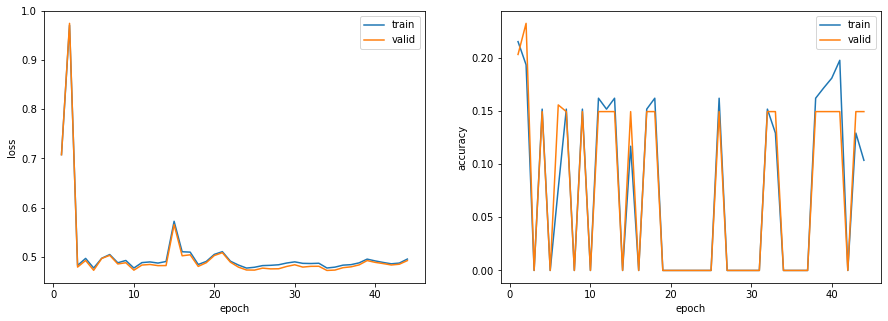

In [49]:
# ログの可視化
x_axis = [x for x in range(1, len(log["train"]) + 1)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x_axis, np.array(log["train"]).T[0], label="train")
ax[0].plot(x_axis, np.array(log["valid"]).T[0], label="valid")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].legend()
ax[1].plot(x_axis, np.array(log["train"]).T[1], label="train")
ax[1].plot(x_axis, np.array(log["valid"]).T[1], label="valid")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend()
plt.show()

In [64]:
def prediction(model, dataset, device):
    # Dataloaderの作成
    loader = DataLoader(dataset, batch_size=100, shuffle=False)

    model.eval()
  
    prob = []
    pred = []
    label = []
    with torch.no_grad():
        for data in loader:
            # デバイスの指定
            ids = data["ids"].to(device)
            mask = data["mask"].to(device)
            label.append(data["labels"].to(device))

            # 順伝播 + 予測値の取得 
            outputs = model.forward(ids, mask)
            prob.append(torch.sigmoid(outputs))
            pred.append(torch.where(outputs>0.5, 1, 0))
            
        pred = torch.cat(pred, dim=0)
        prob = torch.cat(prob, dim=0)
        label = torch.cat(label, dim=0)
        
        del model, loader
        gc.collect()
        return pred, label, prob

In [65]:
pred_train, label_train, prob_train = prediction(model, dataset_train, device)
pred_valid, label_valid, prob_valid = prediction(model, dataset_valid, device)
pred_test, label_test, prob_test = prediction(model, dataset_test, device)

In [66]:
dataTypes = ["pred", "label", "prob"]
trains = [pred_train, label_train, prob_train]
valids = [pred_valid, label_valid, prob_valid]
tests = [pred_test, label_test, prob_test ]

In [68]:
trains = dict(zip(dataTypes, [pd.DataFrame(_.cpu().numpy(), columns=target_col_name) for _ in trains]))
valids = dict(zip(dataTypes, [pd.DataFrame(_.cpu().numpy(), columns=target_col_name) for _ in valids]))
tests = dict(zip(dataTypes, [pd.DataFrame(_.cpu().numpy(), columns=target_col_name) for _ in tests]))

In [69]:
#precision, recallの算出
def calculate_pr_rc(pred, label):
    pr_rc = []
    for col in pred.columns:
        pr = precision_score(pred.loc[:, col].values, label.loc[:, col].values)
        rc = recall_score(pred.loc[:, col].values, label.loc[:, col].values)
        pr_rc.append([pr, rc])
    return pr_rc

In [73]:
test_pr_rc = pd.DataFrame(
    calculate_pr_rc(tests["pred"], tests["label"]),
    index=target_col_name,
    columns=["precision", "recall"]
).T

In [74]:
def plot_performance(performances):
    plt.rcParams["font.size"] = 16
    
    length = len(performances.columns)
    
    plt.figure(figsize=(25, 10))
    left = np.arange(length)
    
    plt.bar(left - 0.2, performances.loc["precision", :], width=0.4, label="precision")
    plt.bar(left + 0.2, performances.loc["recall", :], width=0.4, label="recall")
    plt.xticks(np.arange(length), performances.columns.tolist(), rotation=90)
    plt.yticks(np.arange(11)*0.1, np.round(np.arange(11)*0.1, 1))
    plt.grid(axis="y")
    plt.title("precision (正確さ) vs recall (カバー率)")
    plt.legend(loc="upper left")
    plt.show()

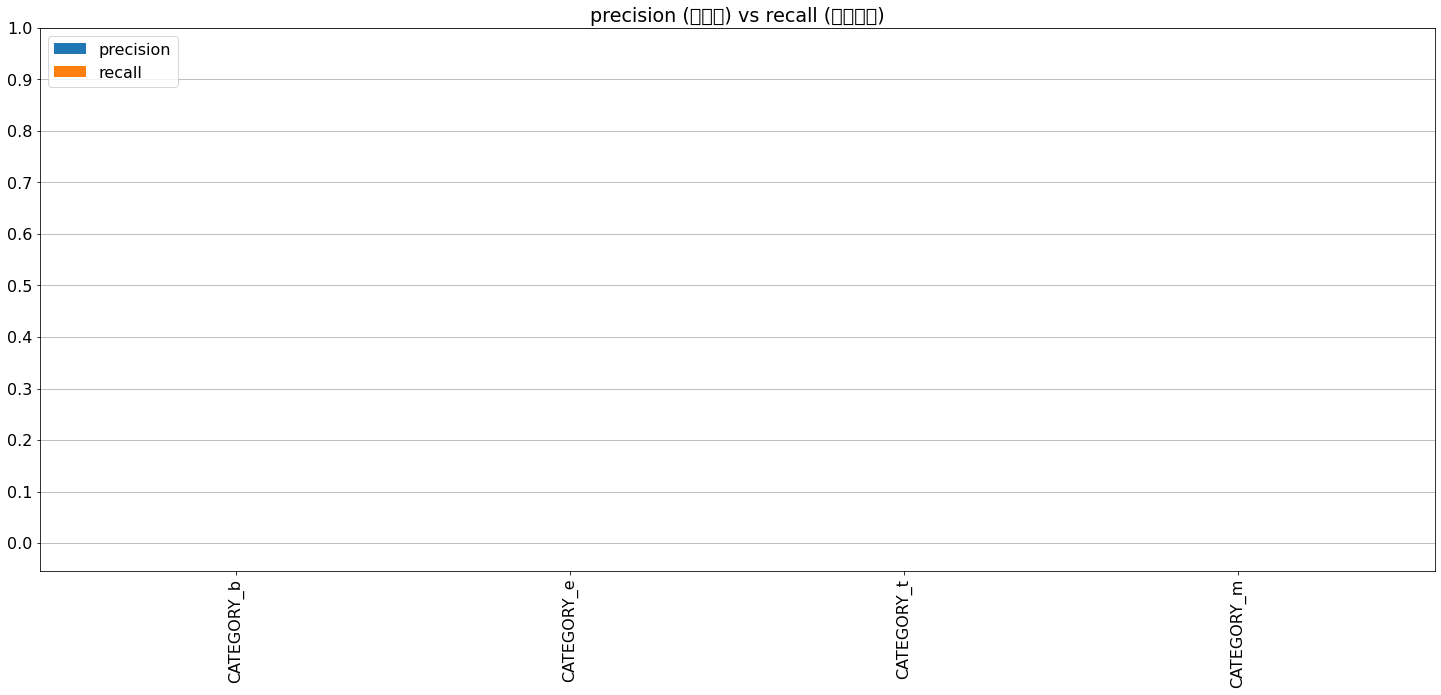

In [75]:
plot_performance(test_pr_rc)